In [1]:
from ncempy import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D

In [2]:
loaded_data = io.dm.dmReader("n-inse_C1_EFTEM-SI-001 [-3,36] eV.dm4")


In [3]:
units = loaded_data['pixelUnit']
coord = loaded_data['coords']

In [7]:
coord[0].shape

(71,)

In [16]:
print(loaded_data['pixelSize'])
print(loaded_data['pixelUnit'])

[0.5, 1.0, 1.0]
['eV', '', '']


In [4]:
dmFile = io.dm.fileDM("EFTEM-SI_01 [0,35] eV_cor.dm4")

In [50]:
dmFile.allTags

{'.ApplicationBounds': array([   0.,    0., 1750., 2820.]),
 '.DocumentObjectList.1.AnnotationType': 20,
 '.DocumentObjectList.1.BackgroundColor': array([-1., -1., -1.]),
 '.DocumentObjectList.1.BackgroundMode': 2,
 '.DocumentObjectList.1.FillMode': 1,
 '.DocumentObjectList.1.ForegroundColor': array([-1., -1.,  0.]),
 '.DocumentObjectList.1.HasBackground': 0,
 '.DocumentObjectList.1.ImageDisplayInfo.BrightColor': array([-1., -1., -1.]),
 '.DocumentObjectList.1.ImageDisplayInfo.Brightness': 0.5,
 '.DocumentObjectList.1.ImageDisplayInfo.CaptionOn': 0,
 '.DocumentObjectList.1.ImageDisplayInfo.CaptionSize': 19,
 '.DocumentObjectList.1.ImageDisplayInfo.CLUT.arraySize': 1536,
 '.DocumentObjectList.1.ImageDisplayInfo.CLUT.arrayOffset': 1094,
 '.DocumentObjectList.1.ImageDisplayInfo.CLUT.arrayType': 2.0,
 '.DocumentObjectList.1.ImageDisplayInfo.CLUT': 'Array unread. Encoded type = 2.0',
 '.DocumentObjectList.1.ImageDisplayInfo.CLUTName': 'Greyscale',
 '.DocumentObjectList.1.ImageDisplayInfo.Co

In [3]:
data_cube = loaded_data["data"]

In [4]:
#Saving the file in numpy for later use
np.save("data/data_cube", data_cube)

In [7]:
data_cube = np.load("data/data_cube.npy")
#This seems to be quicker

fig = plt.figure()
fig.set_size_inches((12,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, projection="3d")

tmp = np.arange(2)
xtmp, ytmp = np.meshgrid(tmp,tmp)
slicetmp = 0*xtmp*ytmp + 1

x = np.arange(2048)

def init():
    ax1.set_title("X-Y data per slice")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.pcolorfast(x, x, data_cube[0,:,:])
    ax2.contourf(xtmp, ytmp, slicetmp, zdir="z", offset=0, cmap="gray")
    ax2.set_zlim(0,72)

def animate(i):
    ax1.pcolorfast(x, x, data_cube[i,:,:])
    ax1.text(0,0, "Slice: "+str(i))
    ax2.clear()
    ax2.set_zlim(0,72)
    ax2.contourf(xtmp, ytmp, slicetmp, zdir="z", offset=i, cmap="gray")

anim = FuncAnimation(fig, animate, init_func=init, frames=70, interval=20)
anim.save("slices.gif");


<img src="slices.gif" />

fig, ax = plt.subplots()
fig.set_size_inches((6,6))

x = np.arange(2048)

def init():
    ax.set_title("EELS data per x=1024 for y={750...1500}")
    ax.set_xlabel("E")
    ax.set_ylabel("Intensity?")
    ax.plot( np.arange( data_cube.shape[0] ), data_cube[:,1024,750] )

def animate(i):
    ax.plot( np.arange( data_cube.shape[0] ), data_cube[:,1024,750+10*i], color=str(1-i/75) )

anim = FuncAnimation(fig, animate, init_func=init, frames=75, interval=20)
anim.save("EELS.gif");

<img src="EELS.gif" />

x = np.arange(400)
X, Y = np.meshgrid(x,x)

slice0 = data_cube[10,900:1300,900:1300]
slice1 = data_cube[15,900:1300,900:1300]
slice2 = data_cube[20,900:1300,900:1300]
slice3 = data_cube[25,900:1300,900:1300]
slice4 = data_cube[30,900:1300,900:1300]

fig = plt.figure()
fig.set_size_inches((6,6))
ax = fig.add_subplot(111, projection="3d")

surface0 = ax.contourf(X, Y, slice0, zdir="z", offset=1, cmap="gray")
surface1 = ax.contourf(X, Y, slice1, zdir="z", offset=3, cmap="gray")
surface2 = ax.contourf(X, Y, slice2, zdir="z", offset=5, cmap="gray")
surface3 = ax.contourf(X, Y, slice2, zdir="z", offset=7, cmap="gray")
surface4 = ax.contourf(X, Y, slice2, zdir="z", offset=9, cmap="gray")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("E")
ax.set_xticks([i for i in range(0,401,100)])
ax.set_yticks([i for i in range(0,401,100)])
ax.set_zticks([0,3,6,9])
ax.set_zlim3d(0,9)
ax.set_title("EFTEM stack")

plt.savefig('eftemstack.png')

<img src="eftemstack.png" />

In [14]:
import scipy.fftpack as sfft

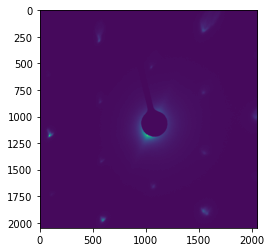

In [15]:
plt.imshow(data_cube[24])

In [25]:
 print(np.unravel_index( np.argmax(sfft.fftshift( sfft.fft2(data_cube[24]) ) ), data_cube[24].shape ))

(1024, 1024)


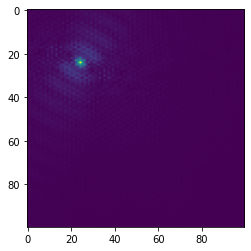

In [26]:
plt.imshow( np.abs( sfft.fftshift( sfft.fft2(data_cube[24]) )[1000:1100,1000:1100] ))

In [75]:
def get_drift(image0, image1):
    form = image0.shape

    image0_transform = sfft.fftshift( sfft.fft( image0 ) )
    image1_transform = sfft.fftshift( sfft.fft( image1 ) )

    cross_pow_spec = (image0_transform * image1_transform.conj())/( np.abs(image0_transform * image1_transform.conj() ) )
    cross_cor = sfft.ifft2( sfft.ifftshift( cross_pow_spec ) )

    shift = np.unravel_index( np.argmax( cross_cor ), form )
    print(np.max( cross_cor ))
    plt.imshow( np.real(cross_cor)[0:10,0:10] )

    return shift



(0.49112588+0j)
(0, 0)


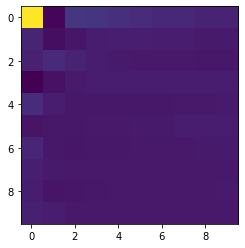

In [76]:
shift = get_drift( data_cube[24], data_cube[25])
print(shift)